In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
from sklearn.metrics import davies_bouldin_score

In [1]:
os.environ["CUDA_VISIBLE_DEVICES"] = "7"  
os.environ["TOKENIZERS_PARALLELISM"] = "false"  

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NameError: name 'os' is not defined

#### BASELINE: RGB

In [ ]:
def get_rgb(image):

    lower = np.array([40, 20, 50], dtype=np.uint8)  # Lower bound for skin color
    upper = np.array([255, 180, 255], dtype=np.uint8)  # Upper bound for skin color

    mask = cv2.inRange(image, lower, upper)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Close gaps

    return mask

In [ ]:
#GEt Average of RGB
def avg(image, mask):
    s = cv2.bitwise_and(image, image, mask=mask)
    s_rgb = cv2.cvtColor(s, cv2.COLOR_BGR2RGB)

    s_pix = s_rgb[mask == 255]
    
    if len(s_pix) == 0:
        return (0, 0, 0)  

    avg_rgb = np.mean(s_pix, axis=0)
    return avg_rgb

In [ ]:
#Calculate Davies-Bouldin Index
def dbi(image, k=3):

    mask = get_rgb(image)
    s_pix = image[mask == 255]
    
    if len(s_pix) < k:
        return None
    
    s_pix_shp = s_pix.reshape(-1, 3)

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(s_pix_shp)

    db_index = davies_bouldin_score(s_pix_shp, kmeans.labels_)
    return db_index

In [ ]:
#Data Processing
def pro(image_path):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    mask = get_rgb(image)
    avg_rgb = avg(image, mask)
    s = cv2.bitwise_and(image, image, mask=mask)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    s_rgb = cv2.cvtColor(s, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title(f"Original Image\nAvg RGB: {tuple(avg_rgb.astype(int))}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(s_rgb)
    plt.title(f"Skin Region\nAvg RGB: {tuple(avg_rgb.astype(int))}")
    plt.axis("off")

    plt.show()

    # Calculate Davies-Bouldin Index
    db_index = dbi(image, k=3)
    
    return db_index  

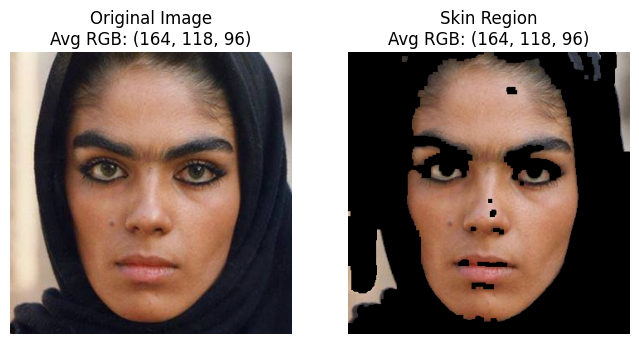

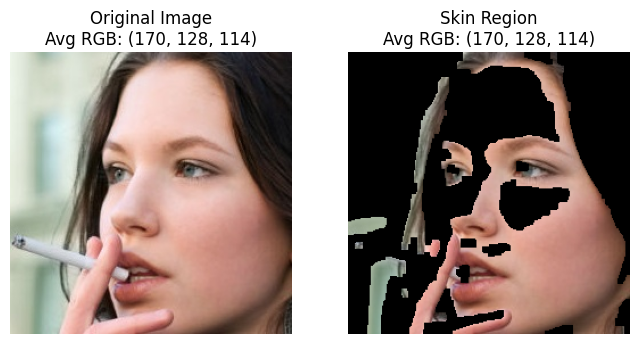

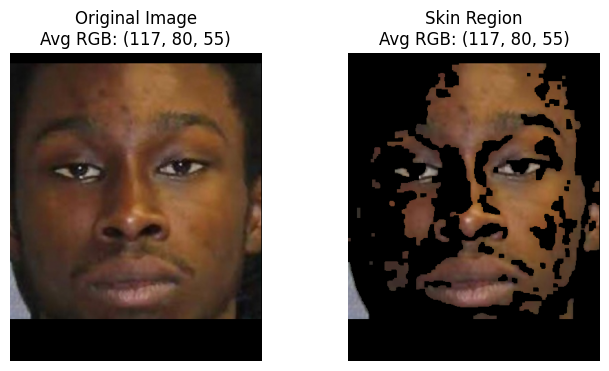

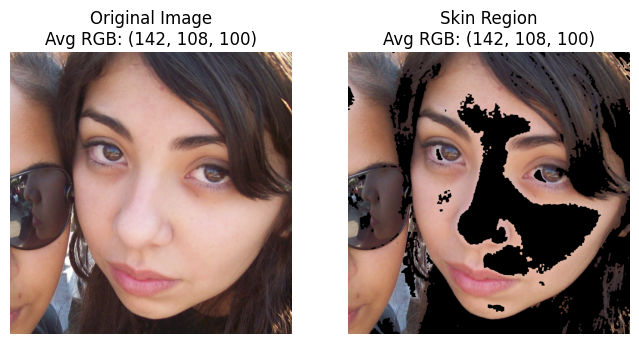

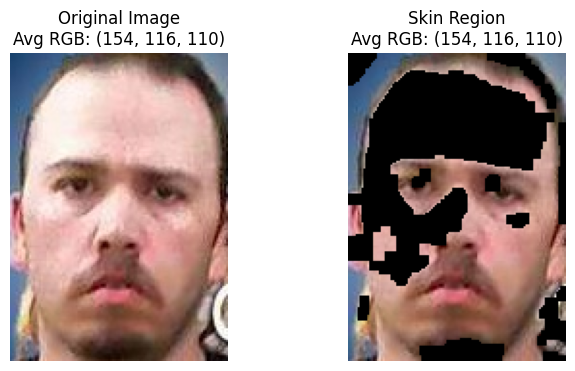

In [1]:
# Directory 
det = "Face"

pths = []
for folder in os.listdir(det):
    folder_path = os.path.join(det, folder)
    
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            
            if os.path.isfile(image_path) and image_path.endswith(('.png', '.jpg', '.jpeg')):
                pths.append(image_path)


db_indexes = []
pro_img = []

for i in range(min(5, len(pths))):
    db_index = pro(pths[i])
    if db_index is not None:
        db_indexes.append(db_index)
        pro_img.append(os.path.basename(pths[i]))



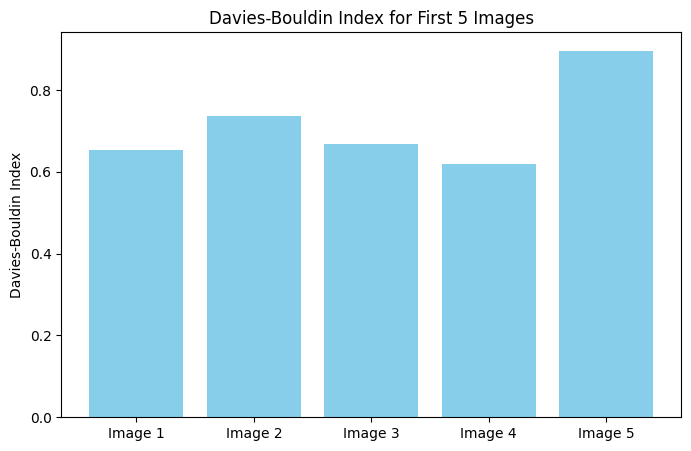

In [3]:
# Plot DB Index for the first 5 images with renamed labels
plt.figure(figsize=(8, 5))
plt.bar([f"Image {i+1}" for i in range(len(db_indexes))], db_indexes, color='skyblue')
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index for First 5 Images")
plt.xticks(rotation=0)
plt.show()


#### Proposed Model

In [ ]:
# Extract skin based on HSV
def s_hsv(image):
    """ Extracts skin regions from an image using refined HSV thresholding. """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([0, 30, 60], dtype=np.uint8)   # Lower threshold for skin tones
    upper = np.array([35, 180, 255], dtype=np.uint8)  # Upper threshold for skin tones
    mask = cv2.inRange(hsv, lower, upper)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask



In [ ]:
#Find dominant colour by k-means
def dom(image, k=3):
    mask = s_hsv(image)
    s = cv2.bitwise_and(image, image, mask=mask)
    pix = s.reshape(-1, 3)
    pix = pix[np.any(pix != [0, 0, 0], axis=1)]  # Remove black pixels 
    
    if len(pix) < k:  
        return None, None
    
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(pix)

    # Compute DB Index
    db_index = davies_bouldin_score(pix, kmeans.labels_)

    # Get dominant skin color 
    dom_c = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))]

    return dom_c, db_index



In [ ]:
# RGB color to HEX 
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))



In [ ]:
# To show dominant skin color 
def s_tone(dom_c):
    s_tone_image = np.ones((100, 100, 3), dtype=np.uint8) * dom_c
    return s_tone_image

In [14]:
# Process the data
def process(det, max_images=5):
    image_count = 0
    db_indexes = []  # Store DB Index values
    lbls = []  # Store labels for graph
    
    for folder in os.listdir(det):
        folder_path = os.path.join(det, folder)
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):
                if image_file.endswith(('jpg', 'png', 'jpeg')): 
                    image_path = os.path.join(folder_path, image_file)
                    image = cv2.imread(image_path)  
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

                    
                    dom_c, db_index = dom(image_rgb)

                    if dom_c is None or db_index is None:
                        continue  

                    # Convert dominant color to hex
                    hex_color = rgb_to_hex(dom_c)

                    # Extract the skin region
                    mask = s_hsv(image_rgb)
                    s_img = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
                    s_tone_image = s_tone(dom_c)

                    plt.subplot(1, 3, 1)
                    plt.imshow(image_rgb)
                    plt.title(f"Original Image\nRGB: {tuple(dom_c.astype(int))}")
                    plt.axis("off")

                    plt.subplot(1, 3, 2)
                    plt.imshow(s_img)
                    plt.title(f"Skin Region\nDominant Color: {hex_color}")
                    plt.axis("off")

                    plt.subplot(1, 3, 3)
                    plt.imshow(s_tone_image)
                    plt.title(f"Skin Tone: {hex_color}")
                    plt.axis("off")

                    plt.show()

            
                    db_indexes.append(db_index)
                    lbls.append(f"Image {image_count+1}")

                    image_count += 1
                    if image_count >= max_images:
                        break
            if image_count >= max_images:
                break

    # Plot DB Index for first 5 images
    plt.figure(figsize=(8, 5))
    plt.bar(lbls, db_indexes, color='skyblue')
    plt.ylabel("Davies-Bouldin Index")
    plt.title("Davies-Bouldin Index for First 5 Images")
    plt.xticks(rotation=0)
    plt.yticks(np.arange(0.0, max(db_indexes) + 0.2, 0.2))
    plt.show()

    






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


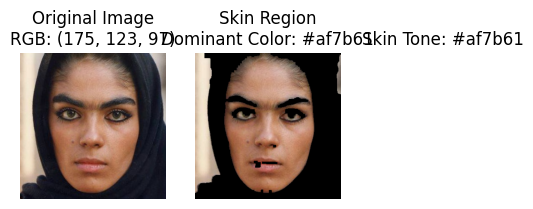

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


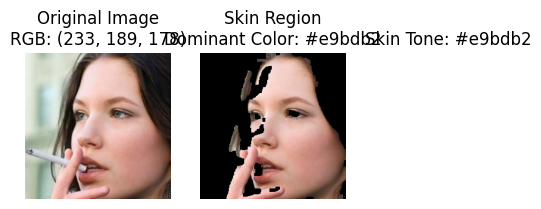

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


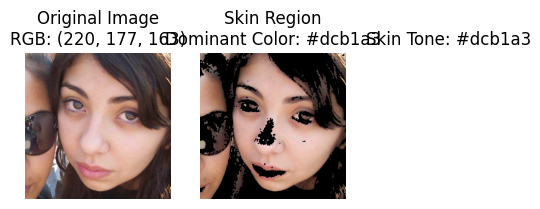

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


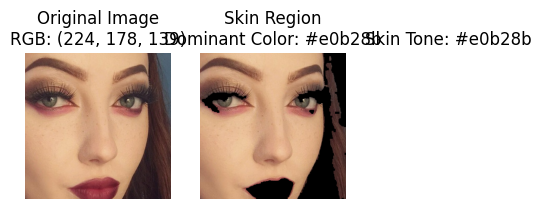

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


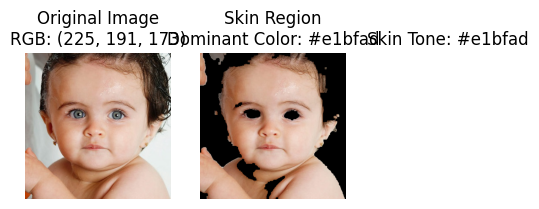

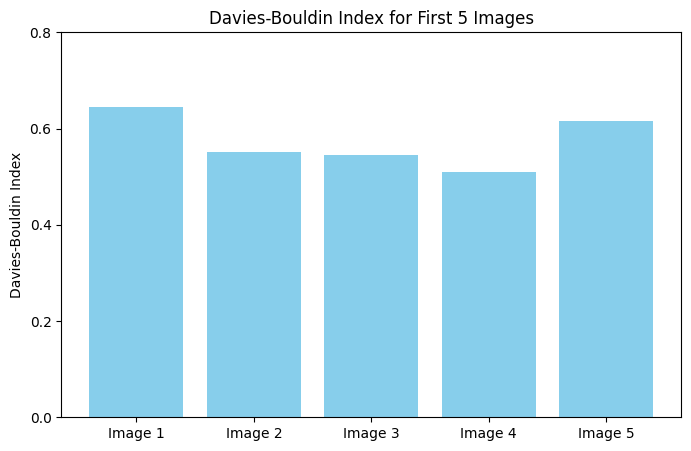

In [15]:
det = "Face"  
process(det, max_images=5)